**Description**: Tries to answer [my answer on
stats.stackexchange.com](https://stats.stackexchange.com/q/611877/337906) by training
BERT on real classification datasets. This experiment suggests that pretraining on test
set features (no labels) can be okay.

**Estimated runtime**: ~30 minutes on a Google Colab GPU or TPU. Eternity on CPU.

In [1]:
import os

import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import permutation_test
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Individual analysis

In [ ]:
# dataset = "ag_news"
# dataset = "enron_spam"
# dataset = "amazon_counterfactual_en"
# dataset = "yelp_review_full"
# dataset = "craigslist_bargains"
# dataset = "emotion"
# dataset = "ethos"
# dataset = "yahoo_answers_topics"
# dataset = "trec"
# dataset = "mtop_domain"
# dataset = "clickbait_notclickbait_dataset"
# dataset = "financial_phrasebank"
# dataset = "app_reviews"
dataset = "rotten_tomatoes"

df = pd.read_csv(os.path.join("accuracies", f"{dataset}.csv"))
print(df.describe().round(3))

In [ ]:
permutation_test(
    data=(df["test"], df["extra"]),
    statistic=lambda x, y: np.mean(x - y),
    alternative="greater",  # acc_test (unfair) > acc_extra (fair)
    permutation_type="samples",  # paired observations
    n_resamples=10_000,
).pvalue

In [ ]:
bins = 10

fig, axes = plt.subplots(
    nrows=len(df.columns), ncols=1, figsize=(6, len(df.columns) * 1.5)
)

axes: list[plt.Axes]

x_common_min = df.min().min()
x_common_max = df.max().max()
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Plot histograms for each column
for i, column in enumerate(df.columns):
    column: str
    df[column].hist(
        bins=bins, ax=axes[i], range=(x_common_min, x_common_max), color=colors[i]
    )
    axes[i].set_ylim((0, 20))
    axes[i].set_xlabel(f"{column} accuracy")
    axes[i].set_ylabel("frequency")

fig.suptitle(f"Dataset: {dataset}", fontsize=12)
plt.tight_layout()
plt.subplots_adjust(hspace=1.2)

In [ ]:
pvals = [
    0.65,
    0.63,
    0.58,
    0.09,
    0.84,
    0.78,
    0.18,
    0.9988,
    0.28,
    0.86,
    0.86,
    0.29,
    0.09,
    0.71,
]
fdrcorrection(pvals)

# Meta-analysis

In [2]:
_dfs = []
for accuracy_csv in sorted(os.listdir("accuracies")):
    _df = pd.read_csv(os.path.join("accuracies", accuracy_csv))
    _df["dataset"] = accuracy_csv.removesuffix(".csv")
    _dfs.append(_df)
accuracy_df = pd.concat(_dfs)
accuracy_df = accuracy_df[["dataset", "base", "extra", "test"]]

In [3]:
num_test = 200  # taken from bert/run.ipynb
num_correct_df = (accuracy_df.copy()[["base", "extra", "test"]] * num_test).astype(int, errors="raise")
num_correct_df["dataset"] = accuracy_df["dataset"].copy()
num_correct_df = num_correct_df[["dataset", "base", "extra", "test"]]
num_correct_df["pair"] = range(len(num_correct_df))
num_correct_df

,dataset,base,extra,test,pair
0,ag_news,142,173,175,0
1,ag_news,146,176,172,1
2,ag_news,147,164,167,2
3,ag_news,159,164,168,3
4,ag_news,153,169,165,4
...,...,...,...,...,...
25,yelp_review_full,57,65,63,415
26,yelp_review_full,62,76,70,416
27,yelp_review_full,54,63,45,417
28,yelp_review_full,52,73,65,418


In [4]:
accuracy_df["diff"] = accuracy_df["test"] - accuracy_df["extra"]
accuracy_df["control"] = accuracy_df["extra"] - accuracy_df["base"]

In [5]:
sns.set_theme(style="darkgrid")

### Does pretraining help?

This is our control.

In [6]:
(accuracy_df
 .groupby("dataset")
 ["control"]
 .describe()
 [["mean", "std"]]
 .round(3)
)

,mean,std
dataset,,
ag_news,0.109,0.047
amazon_counterfactual_en,0.200,0.171
app_reviews,-0.057,0.167
clickbait_notclickbait_dataset,0.012,0.023
craigslist_bargains,0.468,0.167
emotion,0.026,0.104
enron_spam,0.007,0.022
ethos,0.047,0.058
financial_phrasebank,0.112,0.071


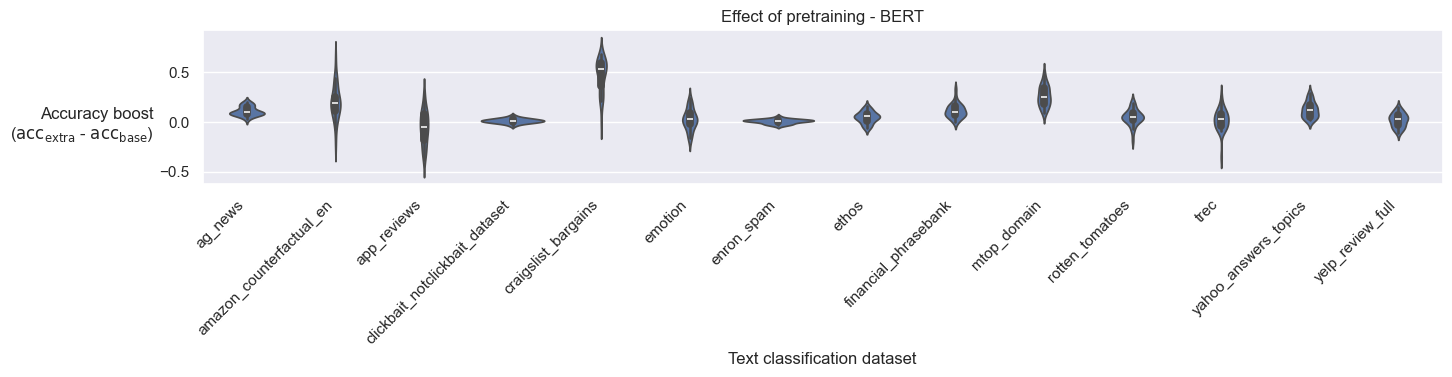

In [7]:
fig, axes = plt.subplots(figsize=(16, 2))
axes: plt.Axes
sns.violinplot(data=accuracy_df, x="dataset", y="control", ax=axes)
axes.set_title("Effect of pretraining - BERT")

axes.yaxis.grid(True)
axes.set_xlabel("Text classification dataset")
axes.set_ylabel(
    "Accuracy boost\n"
    "($\\text{acc}_\\text{extra}$ - $\\text{acc}_\\text{base}$)",
    rotation="horizontal",
    ha="right",
    va="top",
)
plt.xticks(rotation=45, ha="right")

plt.show()

Seems like it does.

In [8]:
control_df = (
    num_correct_df[["pair", "dataset", "base", "extra"]]
    .melt(["pair", "dataset"], var_name="method", value_name="num_correct")
    .sort_values("pair")
    .reset_index(drop=True)
)

In [9]:
model_control = bmb.Model(
    "num_correct ~ method + (1|pair) + (1|dataset)", family="poisson", data=control_df
)

In [10]:
fit_summary = model_control.fit(cores=1, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, method, 1|pair_sigma, 1|pair_offset, 1|dataset_sigma, 1|dataset_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 368 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


In [13]:
az.summary(fit_summary)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,4.534,0.142,4.277,4.804,0.008,0.005,339.0,753.0,1.0
method[extra],0.177,0.007,0.165,0.190,0.000,0.000,7256.0,2935.0,1.0
1|pair_sigma,0.107,0.006,0.094,0.118,0.000,0.000,1366.0,2437.0,1.0
1|dataset_sigma,0.525,0.114,0.332,0.723,0.004,0.003,686.0,1291.0,1.0
1|pair[0],-0.015,0.054,-0.115,0.086,0.001,0.001,3800.0,2623.0,1.0
...,...,...,...,...,...,...,...,...,...
1|dataset[mtop_domain],-0.047,0.144,-0.295,0.244,0.008,0.005,342.0,682.0,1.0
1|dataset[rotten_tomatoes],0.361,0.144,0.104,0.635,0.008,0.005,350.0,692.0,1.0
1|dataset[trec],-0.165,0.144,-0.424,0.112,0.008,0.006,340.0,713.0,1.0
1|dataset[yahoo_answers_topics],-0.716,0.145,-0.977,-0.441,0.008,0.005,355.0,611.0,1.0


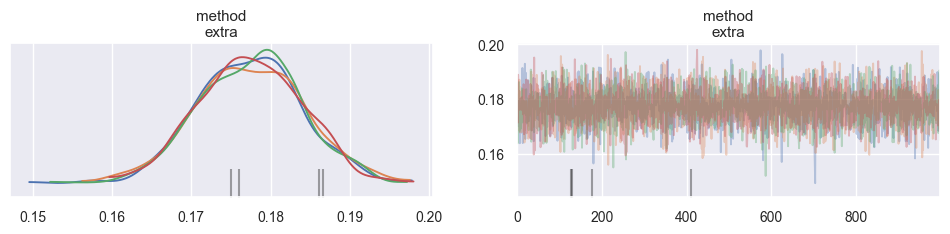

In [14]:
az.plot_trace(fit_summary, compact=False, var_names="method", filter_vars="like");

### Does pretraining on test cause bias?

In [15]:
(accuracy_df
 .groupby("dataset")
 ["diff"]
 .describe()
 [["mean", "std"]]
 .round(3)
)

,mean,std
dataset,,
ag_news,-0.001,0.022
amazon_counterfactual_en,-0.007,0.126
app_reviews,0.038,0.151
clickbait_notclickbait_dataset,-0.004,0.022
craigslist_bargains,-0.024,0.128
emotion,-0.013,0.086
enron_spam,-0.000,0.016
ethos,0.007,0.041
financial_phrasebank,0.005,0.053


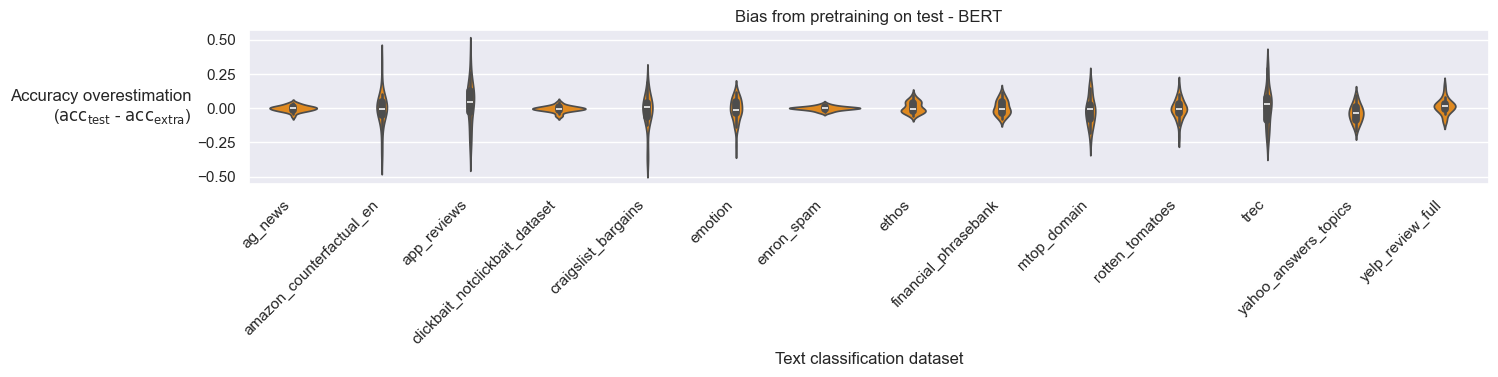

In [16]:
fig, axes = plt.subplots(figsize=(16, 2))
axes: plt.Axes
sns.violinplot(data=accuracy_df, x="dataset", y="diff", ax=axes, color="darkorange")
axes.set_title("Bias from pretraining on test - BERT")

axes.yaxis.grid(True)
axes.set_xlabel("Text classification dataset")
axes.set_ylabel(
    "Accuracy overestimation\n"
    "($\\text{acc}_\\text{test}$ - $\\text{acc}_\\text{extra}$)",
    rotation="horizontal",
    ha="right",
    va="center",
)
plt.xticks(rotation=45, ha="right")

plt.show()

In [18]:
diff_df = (
    num_correct_df[["pair", "dataset", "test", "extra"]]
    .melt(["pair", "dataset"], var_name="method", value_name="num_correct")
    .sort_values("pair")
    .reset_index(drop=True)
)

In [19]:
model_diff = bmb.Model(
    "num_correct ~ method + (1|pair) + (1|dataset)", family="poisson", data=diff_df
)

In [20]:
fit_summary_diff = model_diff.fit(cores=1, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, method, 1|pair_sigma, 1|pair_offset, 1|dataset_sigma, 1|dataset_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 383 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [21]:
az.summary(fit_summary_diff)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,4.700,0.142,4.458,4.975,0.009,0.006,273.0,458.0,1.01
method[test],-0.004,0.006,-0.016,0.008,0.000,0.000,3987.0,2906.0,1.00
1|pair_sigma,0.132,0.006,0.120,0.144,0.000,0.000,1501.0,2360.0,1.00
1|dataset_sigma,0.518,0.124,0.319,0.744,0.005,0.004,524.0,984.0,1.01
1|pair[0],0.013,0.053,-0.088,0.111,0.001,0.001,2514.0,2734.0,1.00
...,...,...,...,...,...,...,...,...,...
1|dataset[mtop_domain],0.098,0.143,-0.163,0.366,0.009,0.006,268.0,493.0,1.01
1|dataset[rotten_tomatoes],0.317,0.143,0.055,0.584,0.008,0.006,296.0,566.0,1.01
1|dataset[trec],-0.196,0.143,-0.453,0.068,0.009,0.006,271.0,466.0,1.01
1|dataset[yahoo_answers_topics],-0.633,0.145,-0.897,-0.369,0.008,0.006,298.0,504.0,1.01


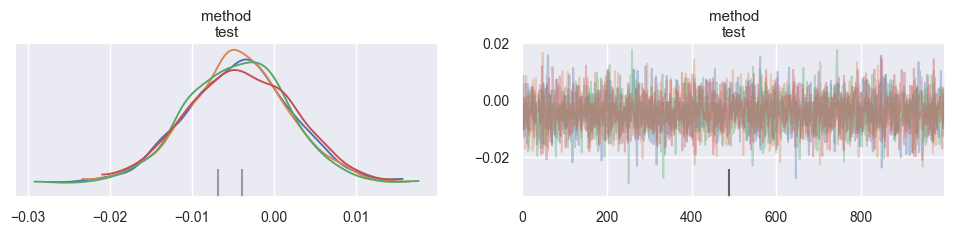

In [22]:
az.plot_trace(fit_summary_diff, compact=False, var_names="method", filter_vars="like");